In [34]:
import sys
root = '/home/featurize/data'
sys.path.append(f'{root}/pikachu/utils')
sys.path.append(f'{root}/pikachu/third')
sys.path.append(f'{root}/pikachu')
sys.path.append(f'{root}/pikachu/projects/ai/naic_seg')

In [35]:
!pip install -q overrides
!pip install -q transformers

In [58]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gezi
from gezi.metrics.image.semantic_seg import Evaluator
import melt as mt

In [37]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [38]:
CLASSES = ['water', 'track', 'build', 'arable', 'grass', 'forest', 'bare', 'other']
CLASSES_V2 = ['water', 'track_road', 'build', 'track_airport', 'other_park', 'other_playground', 
            'arable_natural', 'arable_greenhouse',
            'grass_natural', 'grass_greenbelt', 
            'forest_natural', 'forest_planted', 
            'bare_natural', 'bare_planted', 'other_other']

In [39]:
import cv2

In [40]:
def read(x):
    return cv2.imread(x, cv2.IMREAD_UNCHANGED)

In [41]:
read('../input/eval.all/label/5_1.png')

array([[1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [42]:
def eval_v1(out_dir='../working/ensemble/out.v1', label_dir='../input/naic/dv1/train/label', files=None, n=4):
  m = {}
  for i in range(17):
    if i < 4:
      m[i + 1] = i
    else:
      m[i + 1] = i - 2
  m2 = {
    0: 0,
    1: 1,
    2: 2,
    3: 1,
    4: 7,
    5: 7,
    6: 3,
    7: 3,
    8: 4,
    9: 4,
    10: 5,
    11: 5,
    12: 6,
    13: 6,
    14: 7,
  }   

  if not files:
    files = glob.glob(f'{out_dir}/*')
  np.random.shuffle(files)
  files = files[:n]
  for file in files:
    index = os.path.basename(file).split('.')[0]
    label = (read(f'{label_dir}/{index}.png') / 100 - 1).astype(np.uint8)
    try:
      pred = read(f'{out_dir}/{index}.png').astype(np.uint8)
      f = np.vectorize(lambda x: m[x])
      pred = f(pred).astype(np.uint8)
      f = np.vectorize(lambda x: m2[x])
      pred = f(pred).astype(np.uint8)
    except Exception:
      pred = label    
    print(index, Evaluator(CLASSES).eval(label[np.newaxis, :, :], pred[np.newaxis, :, :]))
    image_dir = label_dir.replace('label', 'image')
    gezi.plot.segmentation_eval(
        read(f'{image_dir}/{index}.tif'),
        label,
        pred,
        CLASSES,
    )

In [43]:
# eval_v1('../input/out.v1.1119', '../input/eval.naic.v1/label')

In [44]:
def eval_ccf(out_dir='../working/ensemble/out.v1', label_dir='../input/eval.all/label/', round=2, n=4):
    files = glob.glob(f'{out_dir}/*')
    np.random.shuffle(files)
    files = files[:n]
    m = {}
    for i in range(17):
      if i < 4:
        m[i + 1] = i
      else:
        m[i + 1] = i - 2

    if round == 2:
      m2 = {
        0: 4,
        1: 2,
        2: 3,
        3: 2,
        4: 0,
        5: 0,
        6: 1,
        7: 1,
        8: 1,
        9: 1,
        10: 1,
        11: 1,
        12: 1,
        13: 1,
        14: 0,
      }
    else:
      m2 = {
        0: 4,
        1: 2,
        2: 3,
        3: 1,
        4: 0,
        5: 0,
        6: 0,
        7: 0,
      }
    for file in files:
        index = os.path.basename(file).split('.')[0]
        label = (read(f'{label_dir}/{index}.png')).astype(np.uint8)
        pred = (read(f'{out_dir}/{index}.png')).astype(np.uint8)
#         print(pred, pred.max(), pred.min())
        f = np.vectorize(lambda x: m[x])
        pred = f(pred).astype(np.uint8)
        f = np.vectorize(lambda x: m2[x])
        pred = f(pred).astype(np.uint8)
        print(index, Evaluator(CLASSES).eval(label[np.newaxis, :, :], pred[np.newaxis, :, :]))
        image_dir = label_dir.replace('label', 'image')
        gezi.plot.segmentation_eval(
            read(f'{image_dir}/{index}.png'),
            label,
            pred,
            CLASSES,
        )

In [45]:
# eval_ccf('../input/out.ccf.naic/', n=4)

In [46]:
# eval_ccf('../input/out.ccf.large', '../input/eval.large/label/', n=1)

In [47]:
m = {}
for i in range(17):
  if i < 4:
    m[i + 1] = i
  else:
    m[i + 1] = i - 2
f = np.vectorize(lambda x: m[x])
def eval_v2(out_dir='../input/out', label_dir='../input/naic/dv2/train/label', files=None, n=4):
  if not files:
    if os.path.isdir(out_dir):
      files = glob.glob(f'{out_dir}/*')
      np.random.shuffle(files)
      files = files[:n]
    else:
      if not out_dir.endswith('.png'):
        out_dir += '.png'
      files = [out_dir]
      out_dir = os.path.dirname(out_dir)
  for file in files:
    index = os.path.basename(file).split('.')[0]
    label = f(read(f'{label_dir}/{index}.png')).astype(np.uint8)
    try:
      pred = f(read(f'{out_dir}/{index}.png')).astype(np.uint8)
    except Exception:
      pred = label
    print(index, Evaluator(CLASSES_V2).eval(label[np.newaxis, :, :], pred[np.newaxis, :, :]))
    image_dir = label_dir.replace('label', 'image')
    gezi.plot.segmentation_eval(
        read(f'{image_dir}/{index}.tif'),
        label,
        pred,
        CLASSES_V2,
    )

In [48]:
def infer_v2(out_dir='../input/out.google', image_dir='../input/eval.google/image', n=4):
  files = glob.glob(f'{out_dir}/*')
  np.random.shuffle(files)
  files = files[:n]
  suffix = 'tif' if not 'google' in out_dir else 'jpg'
  for file in files:
    index = os.path.basename(file).split('.')[0]
    print(index)
    pred = f(read(f'{out_dir}/{index}.png')).astype(np.uint8)
    gezi.plot.segmentation(
        read(f'{image_dir}/{index}.{suffix}'),
        pred,
        CLASSES_V2,
    )

In [49]:
!ls ../input/out/8180.png

ls: cannot access '../input/out/8180.png': No such file or directory


In [50]:
eval_v1(files=['../input/naic/dv1/train/image/444542.tif'])

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [51]:
eval_v2(n=2)

KeyError: None

In [52]:
eval_v2(files=['../input/naic/dv2/train/image/17722.tif'])

KeyError: None

In [60]:
# %%capture #disable output
infer_v2('../input/out.google', n=20)

7


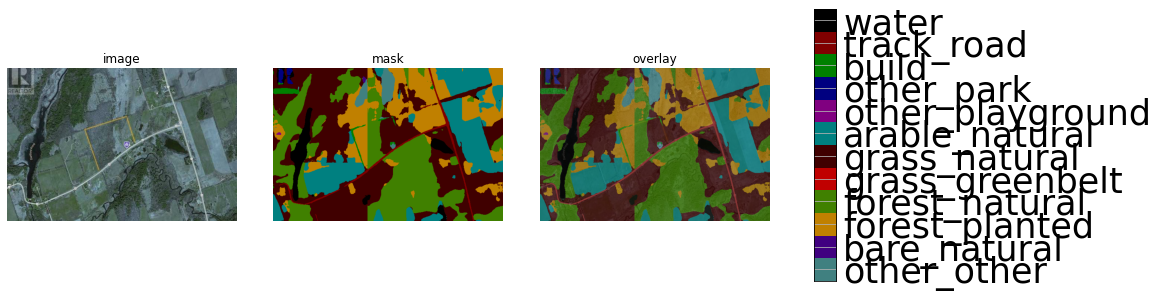

11


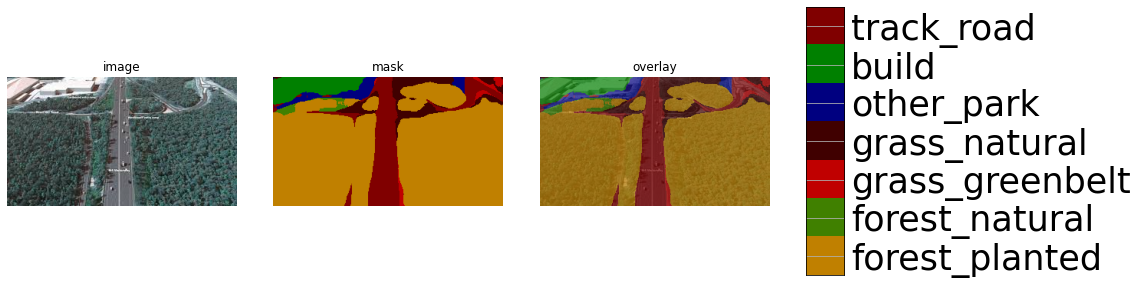

8


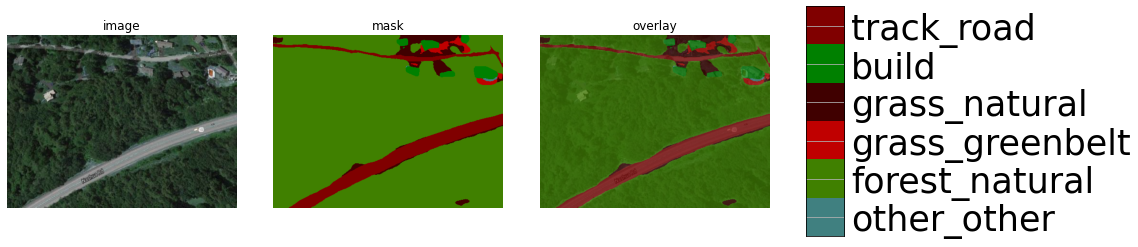

1


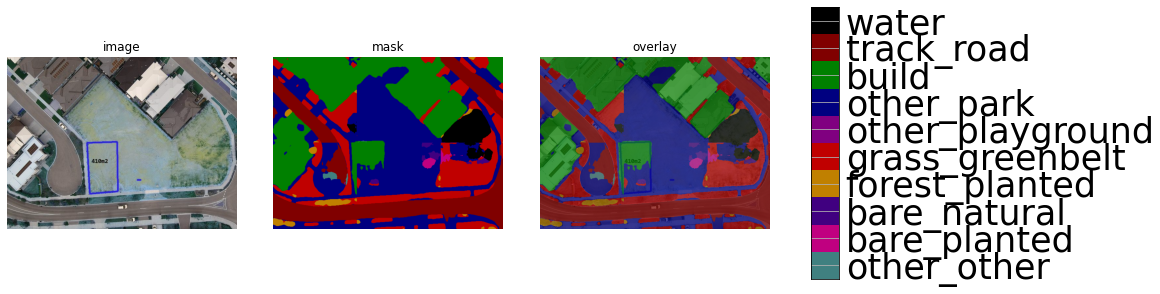

6


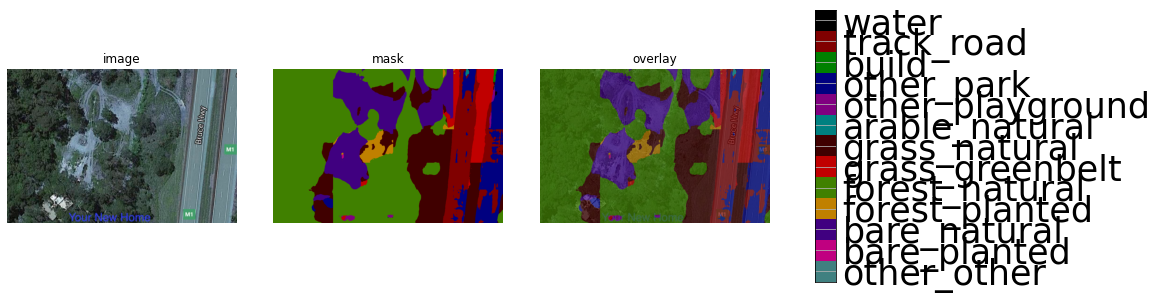

15


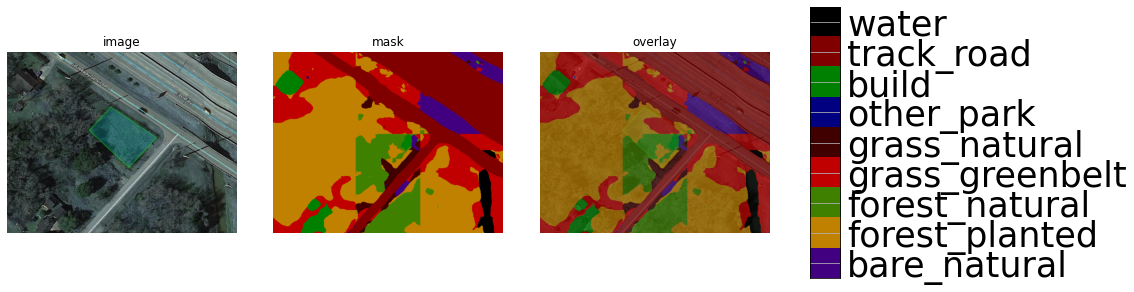

17


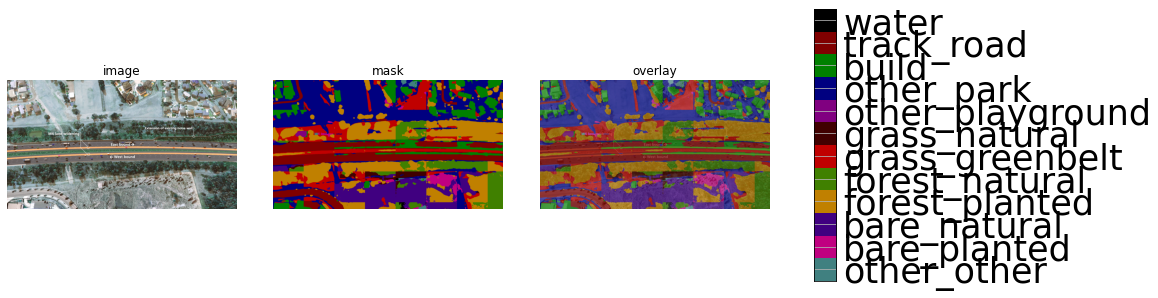

2


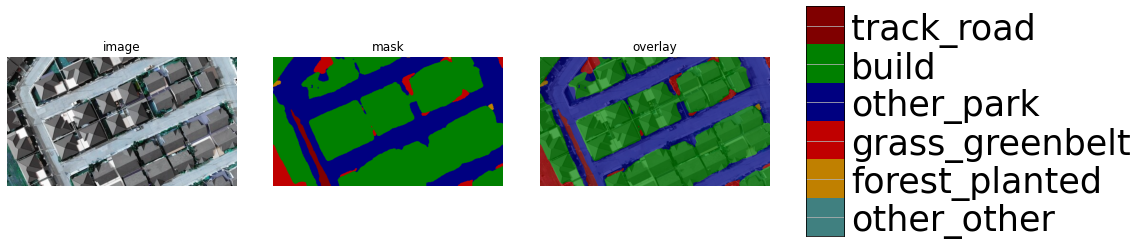

13


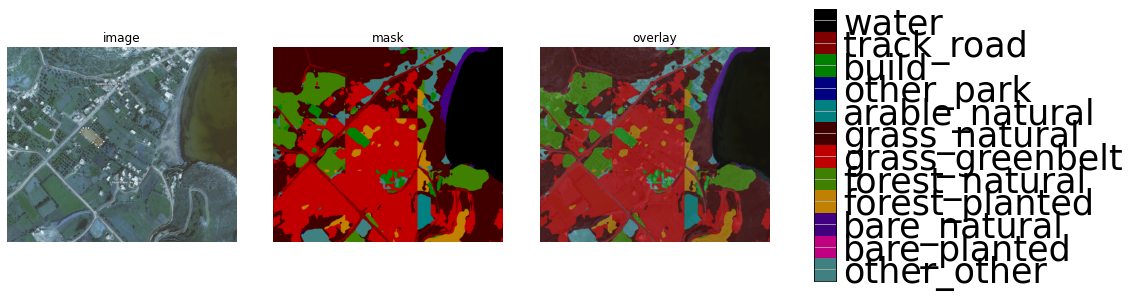

16


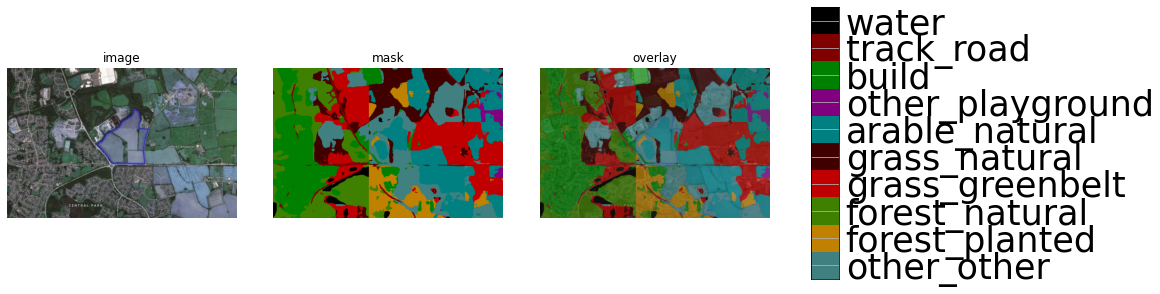

22


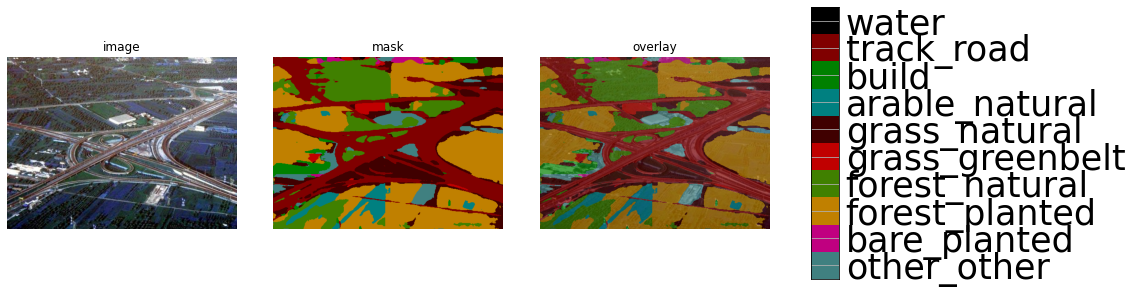

19


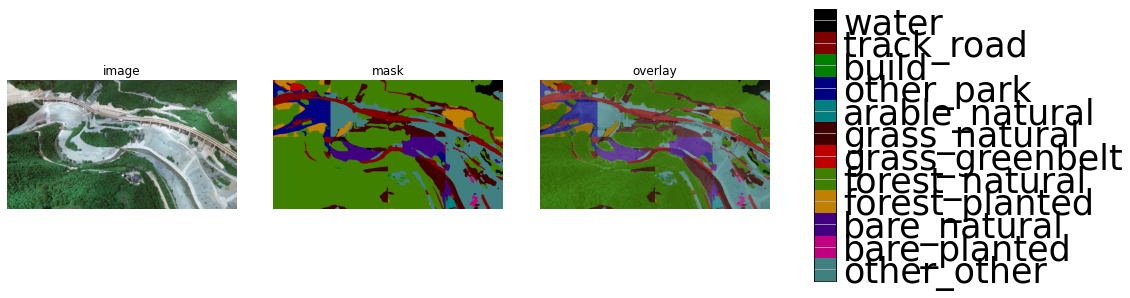

5


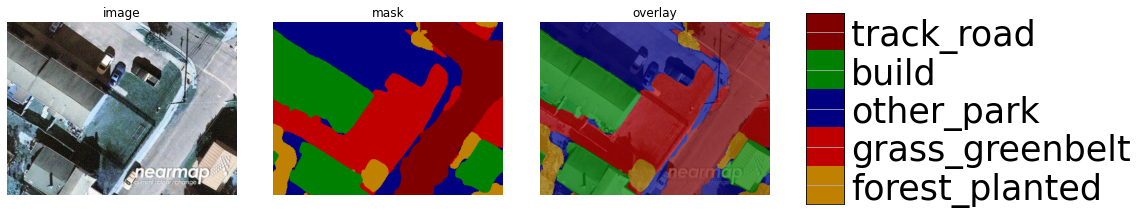

9


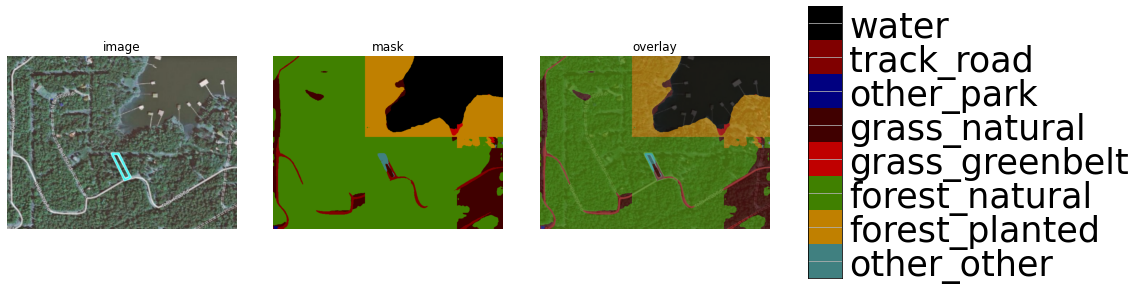

12


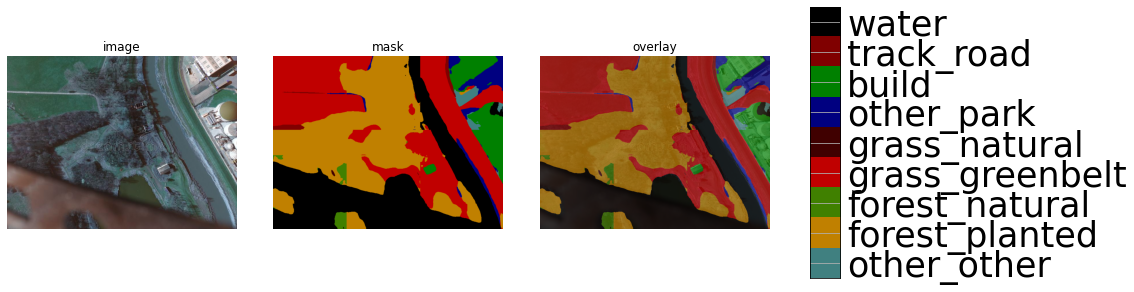

10


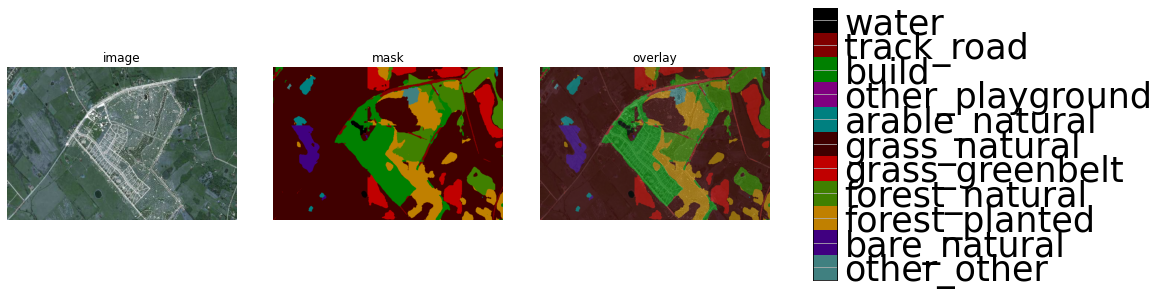

4


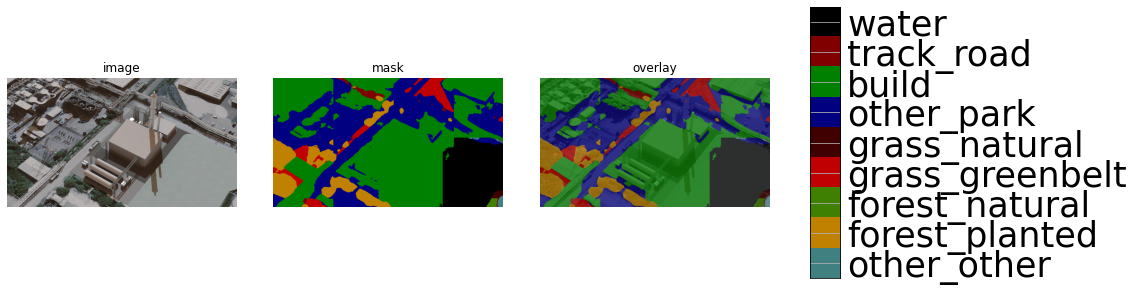

18


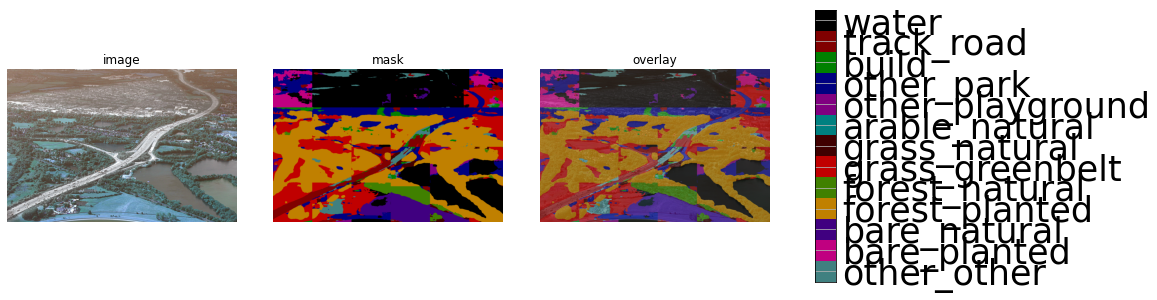

3


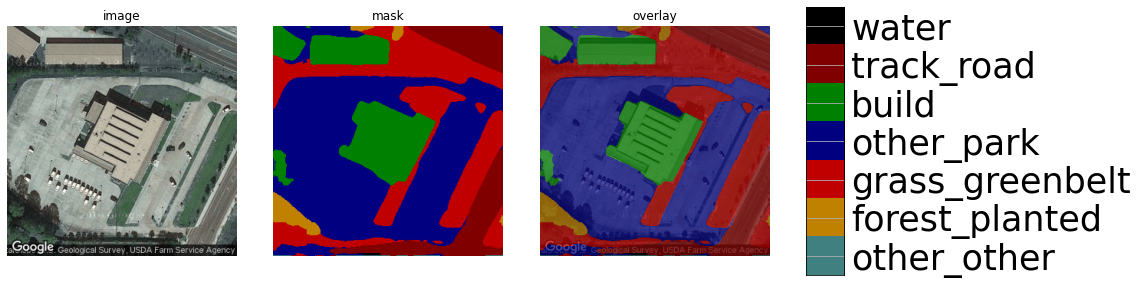

14


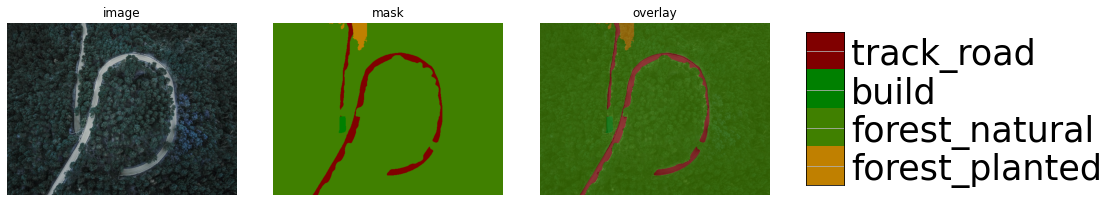

In [54]:
infer_v2('../input/out.google', n=20)

In [18]:
# infer_v2('../input/out.google', n=20)

36376 {'FWIoU': 0.9895356448575086, 'MIoU': 0.6843942433618254, 'ACC/pixel': 0.994415283203125, 'ACC/class': 0.9908556461499156, 'IoU/water': 0.9893112258199072, 'IoU/track_road': nan, 'IoU/build': nan, 'IoU/track_airport': nan, 'IoU/other_park': 0.7560606060606061, 'IoU/other_playground': nan, 'IoU/arable_natural': nan, 'IoU/arable_greenhouse': nan, 'IoU/grass_natural': nan, 'IoU/grass_greenbelt': nan, 'IoU/forest_natural': 0.0, 'IoU/forest_planted': nan, 'IoU/bare_natural': 0.9922051415667883, 'IoU/bare_planted': nan, 'IoU/other_other': nan}


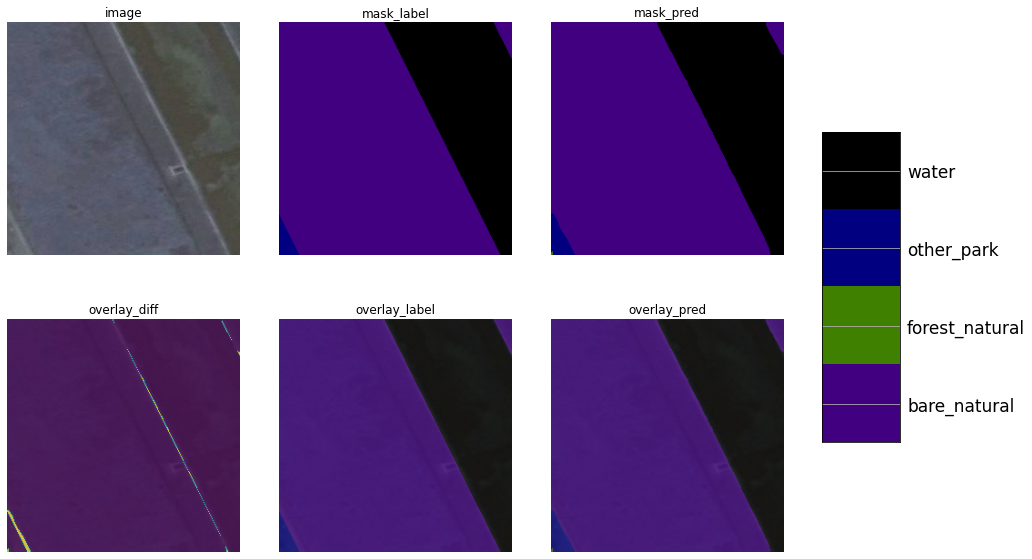

15237 {'FWIoU': 0.9901538748709923, 'MIoU': 0.9052955480281047, 'ACC/pixel': 0.9950408935546875, 'ACC/class': 0.9102215767394467, 'IoU/water': nan, 'IoU/track_road': nan, 'IoU/build': nan, 'IoU/track_airport': nan, 'IoU/other_park': 0.994425599032042, 'IoU/other_playground': nan, 'IoU/arable_natural': nan, 'IoU/arable_greenhouse': nan, 'IoU/grass_natural': 0.983179795052272, 'IoU/grass_greenbelt': nan, 'IoU/forest_natural': nan, 'IoU/forest_planted': nan, 'IoU/bare_natural': nan, 'IoU/bare_planted': nan, 'IoU/other_other': 0.73828125}


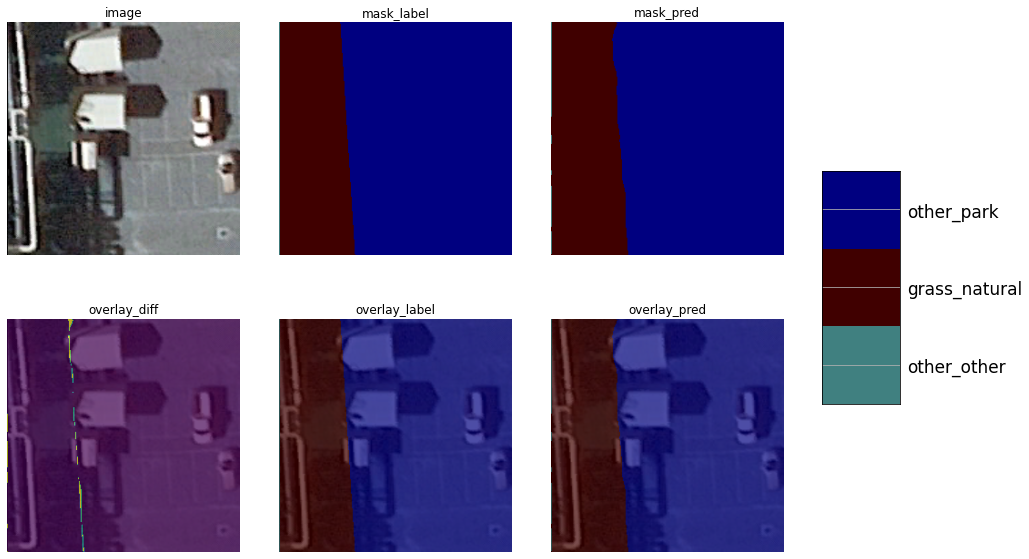

35450 {'FWIoU': 0.936011545999758, 'MIoU': 0.9351970661813606, 'ACC/pixel': 0.9669952392578125, 'ACC/class': 0.9649579518939022, 'IoU/water': nan, 'IoU/track_road': nan, 'IoU/build': nan, 'IoU/track_airport': nan, 'IoU/other_park': 0.9275498241500586, 'IoU/other_playground': nan, 'IoU/arable_natural': nan, 'IoU/arable_greenhouse': nan, 'IoU/grass_natural': nan, 'IoU/grass_greenbelt': nan, 'IoU/forest_natural': nan, 'IoU/forest_planted': nan, 'IoU/bare_natural': nan, 'IoU/bare_planted': nan, 'IoU/other_other': 0.9428443082126625}


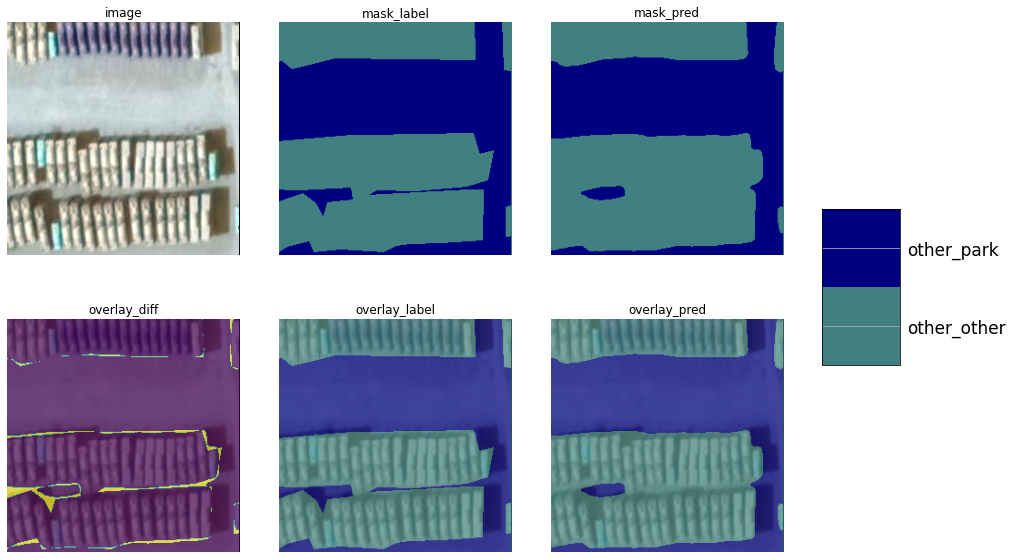

99900 {'FWIoU': 0.5193718791510381, 'MIoU': 0.37405338986333175, 'ACC/pixel': 0.64691162109375, 'ACC/class': 0.5986780377672158, 'IoU/water': 0.160149511213341, 'IoU/track_road': 0.7343649258542876, 'IoU/build': 0.3248780487804878, 'IoU/track_airport': nan, 'IoU/other_park': nan, 'IoU/other_playground': nan, 'IoU/arable_natural': nan, 'IoU/arable_greenhouse': nan, 'IoU/grass_natural': 0.4673469387755102, 'IoU/grass_greenbelt': nan, 'IoU/forest_natural': 0.332820381294349, 'IoU/forest_planted': 0.7680631147950268, 'IoU/bare_natural': 0.013302486986697512, 'IoU/bare_planted': 0.4172873382987064, 'IoU/other_other': 0.14826776277157958}


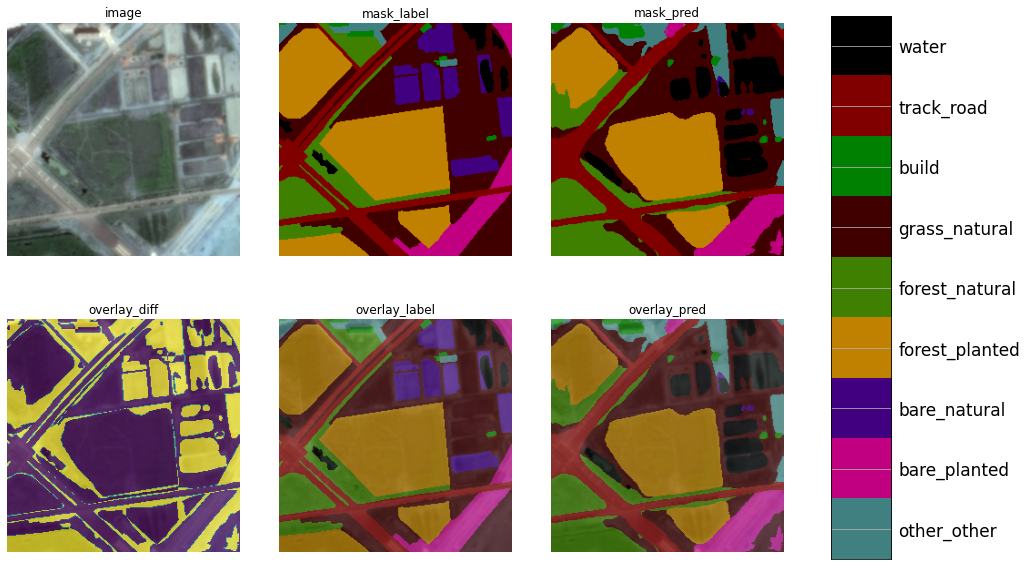

57980 {'FWIoU': 0.7186283918219992, 'MIoU': 0.33285153279783847, 'ACC/pixel': 0.7823333740234375, 'ACC/class': 0.5247903908556583, 'IoU/water': 0.0, 'IoU/track_road': 0.4, 'IoU/build': 0.49038461538461536, 'IoU/track_airport': nan, 'IoU/other_park': nan, 'IoU/other_playground': nan, 'IoU/arable_natural': 0.8081637721523478, 'IoU/arable_greenhouse': nan, 'IoU/grass_natural': 0.4025822961498197, 'IoU/grass_greenbelt': nan, 'IoU/forest_natural': 0.2205989773557341, 'IoU/forest_planted': 0.00823106854235259, 'IoU/bare_natural': nan, 'IoU/bare_planted': nan, 'IoU/other_other': nan}


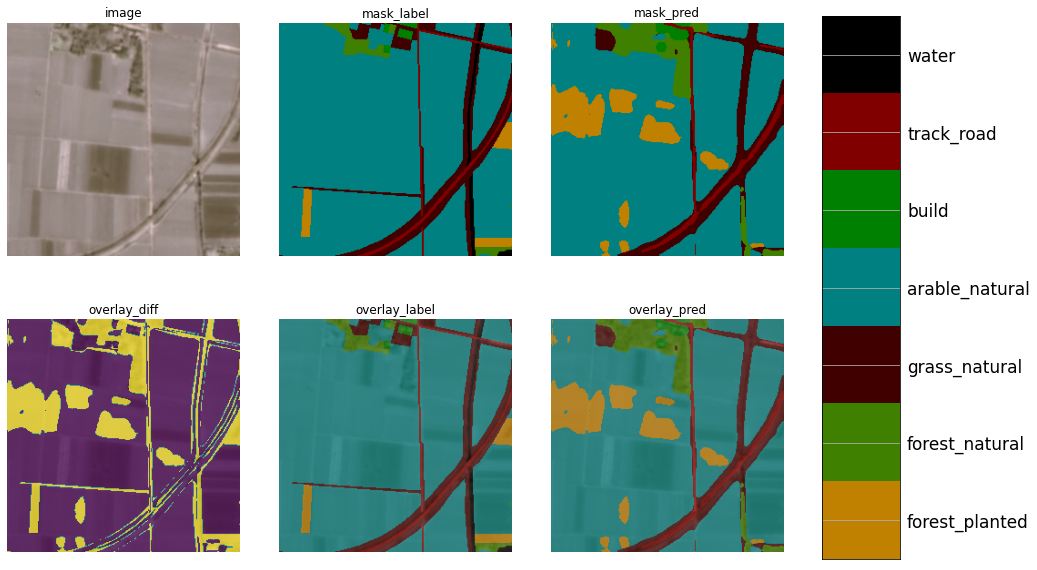

13153 {'FWIoU': 0.26037710334636816, 'MIoU': 0.5228194442783101, 'ACC/pixel': 0.47308349609375, 'ACC/class': 0.7008642869775773, 'IoU/water': nan, 'IoU/track_road': nan, 'IoU/build': nan, 'IoU/track_airport': nan, 'IoU/other_park': nan, 'IoU/other_playground': nan, 'IoU/arable_natural': nan, 'IoU/arable_greenhouse': nan, 'IoU/grass_natural': 0.15362745098039216, 'IoU/grass_greenbelt': nan, 'IoU/forest_natural': nan, 'IoU/forest_planted': nan, 'IoU/bare_natural': 0.41483088185453804, 'IoU/bare_planted': nan, 'IoU/other_other': 1.0}


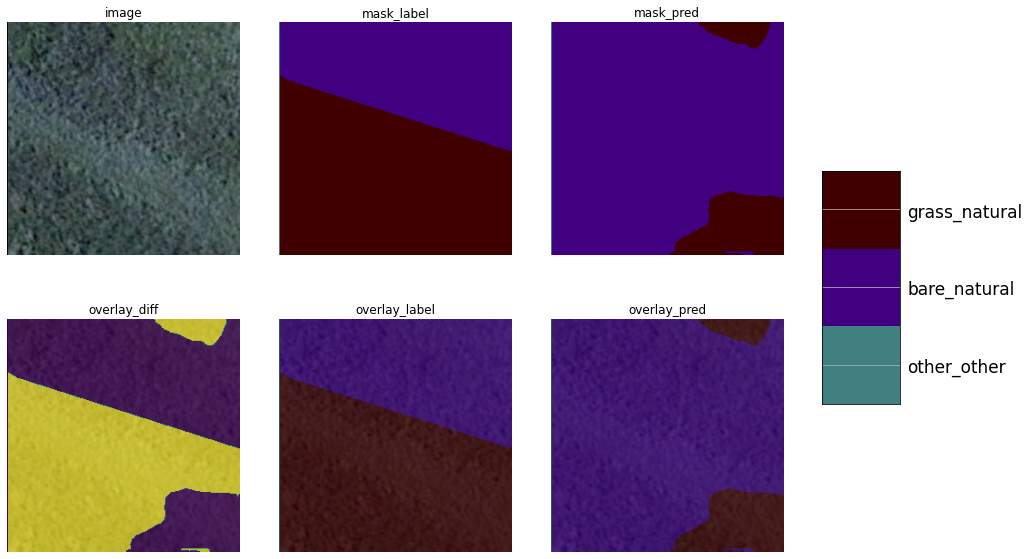

17110 {'FWIoU': 0.9551592354999658, 'MIoU': 0.9448858989591984, 'ACC/pixel': 0.9767913818359375, 'ACC/class': 0.9782049603893003, 'IoU/water': nan, 'IoU/track_road': nan, 'IoU/build': 0.9389572639000556, 'IoU/track_airport': nan, 'IoU/other_park': nan, 'IoU/other_playground': nan, 'IoU/arable_natural': nan, 'IoU/arable_greenhouse': nan, 'IoU/grass_natural': 0.9228314906878385, 'IoU/grass_greenbelt': nan, 'IoU/forest_natural': 0.9728689422897009, 'IoU/forest_planted': nan, 'IoU/bare_natural': nan, 'IoU/bare_planted': nan, 'IoU/other_other': nan}


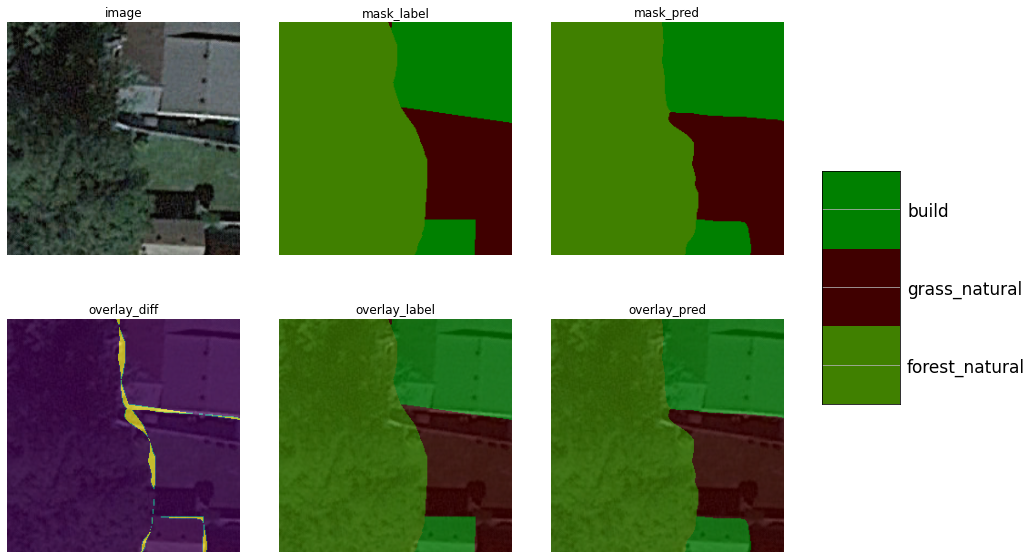

28098 {'FWIoU': 0.924883584730156, 'MIoU': 0.9081749272812736, 'ACC/pixel': 0.960662841796875, 'ACC/class': 0.9431216133064834, 'IoU/water': nan, 'IoU/track_road': 0.8565493963390887, 'IoU/build': nan, 'IoU/track_airport': nan, 'IoU/other_park': nan, 'IoU/other_playground': nan, 'IoU/arable_natural': nan, 'IoU/arable_greenhouse': nan, 'IoU/grass_natural': 0.9497279694233732, 'IoU/grass_greenbelt': nan, 'IoU/forest_natural': 0.8342348433626324, 'IoU/forest_planted': nan, 'IoU/bare_natural': nan, 'IoU/bare_planted': nan, 'IoU/other_other': 0.9921875}


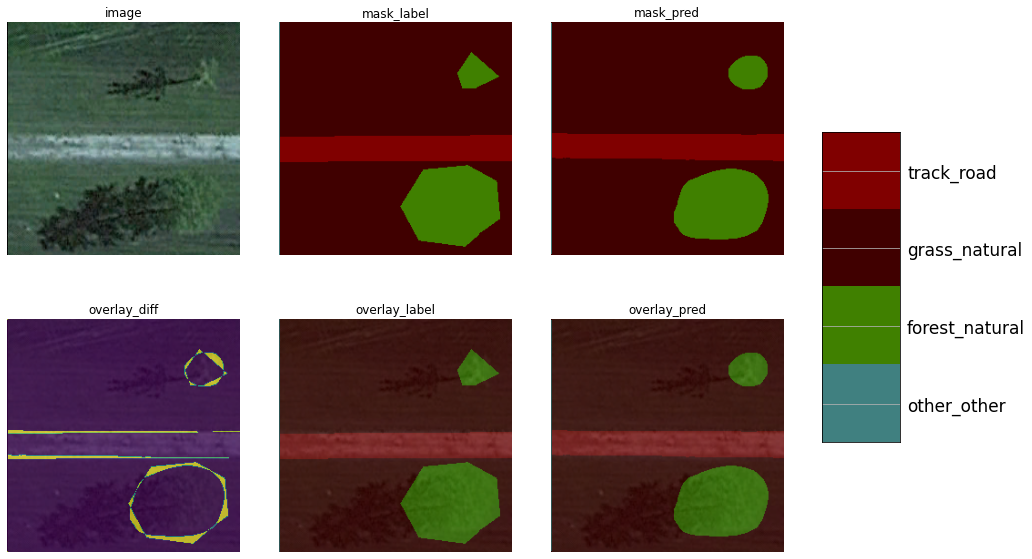

67914 {'FWIoU': 0.6838648089351447, 'MIoU': 0.4140805598033752, 'ACC/pixel': 0.806243896484375, 'ACC/class': 0.5137252464509134, 'IoU/water': 0.0, 'IoU/track_road': 0.47221251310730517, 'IoU/build': 0.8426416439007008, 'IoU/track_airport': nan, 'IoU/other_park': nan, 'IoU/other_playground': 0.7693617021276595, 'IoU/arable_natural': 0.4206081081081081, 'IoU/arable_greenhouse': nan, 'IoU/grass_natural': 0.37265202164915634, 'IoU/grass_greenbelt': nan, 'IoU/forest_natural': 0.552938808373591, 'IoU/forest_planted': 0.0, 'IoU/bare_natural': nan, 'IoU/bare_planted': nan, 'IoU/other_other': 0.29631024096385544}


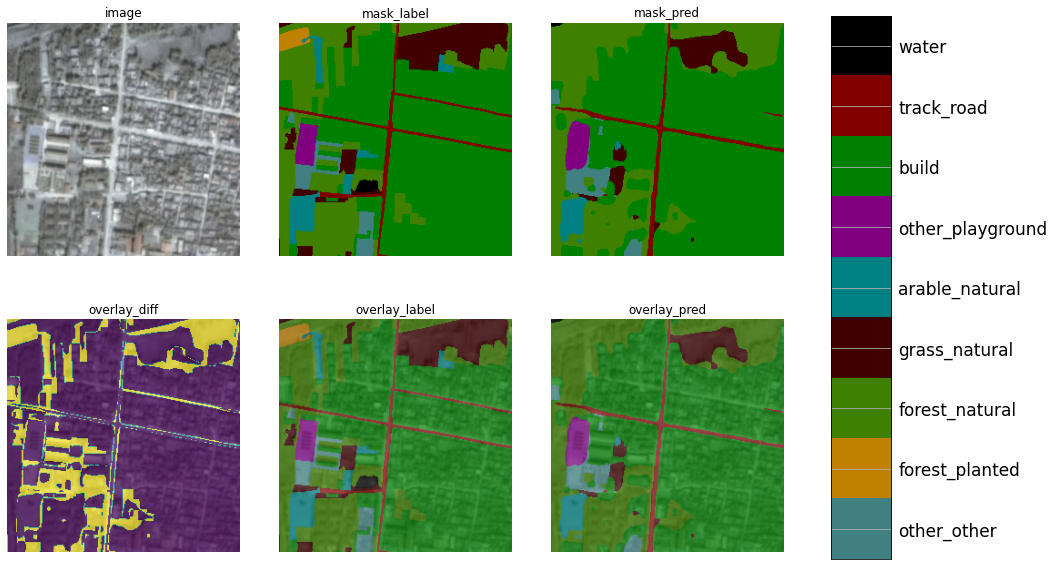

87593 {'FWIoU': 0.6753056053802281, 'MIoU': 0.32598574426518945, 'ACC/pixel': 0.7875823974609375, 'ACC/class': 0.4212782556520769, 'IoU/water': 0.0, 'IoU/track_road': 0.3084753787878788, 'IoU/build': 0.8624445688207689, 'IoU/track_airport': nan, 'IoU/other_park': nan, 'IoU/other_playground': nan, 'IoU/arable_natural': 0.8038075092543627, 'IoU/arable_greenhouse': nan, 'IoU/grass_natural': 0.4457570955193776, 'IoU/grass_greenbelt': 0.0, 'IoU/forest_natural': 0.22393312802463705, 'IoU/forest_planted': 0.20899424786473766, 'IoU/bare_natural': nan, 'IoU/bare_planted': nan, 'IoU/other_other': 0.08045977011494253}


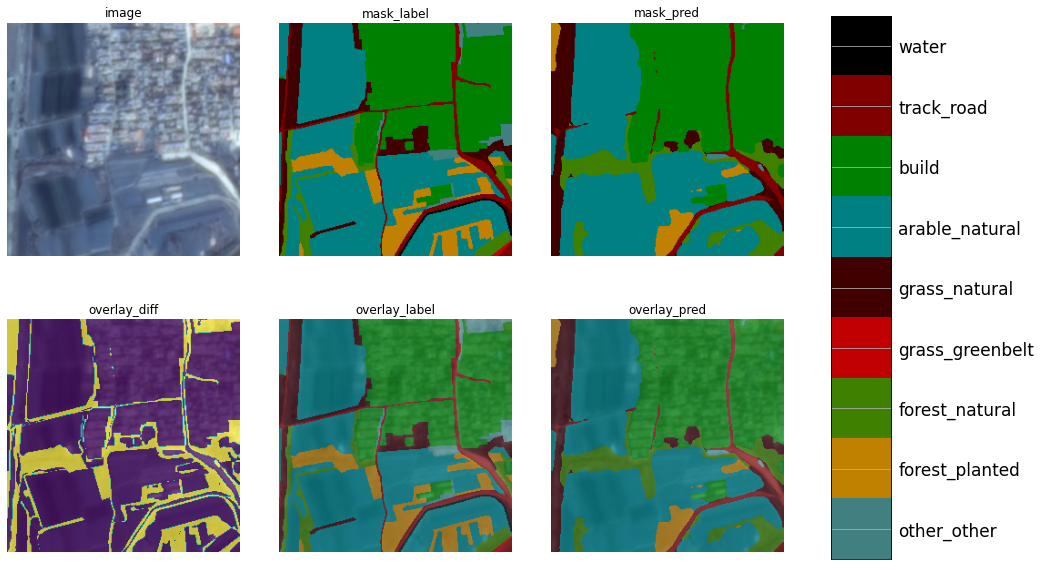

In [23]:
eval_v2(n=10)

In [20]:
ids = [14714, 33932, 265, 25343, 20153, 10759, 15960, 23015, 10173]
# ids = [6847, 20171]
# ids = [47647]
ids = [64748, 49171, 49002, 8875, 14625, 41352, 38415]
files = [f'../input/out/{x}.png' for x in ids]
# eval_v2(files=files)

In [ ]:
def debug(out_dir='../working/ensemble/out.v1',  out_dir2='../working/ensemble/out.v2', n=4):
    files = glob.glob(f'{out_dir2}/*')
    np.random.shuffle(files)
    files = files[:n]
    for file in files:
        index = os.path.basename(file).split('.')[0]
        label = (read(f'../input/train/label/{index}.png') / 100 - 1).astype(np.uint8)
        pred = (read(f'{out_dir}/{index}.png') / 100 -1).astype(np.uint8)
        print(index, Evaluator(CLASSES).eval(label[np.newaxis, :, :], pred[np.newaxis, :, :]))
        gezi.plot.segmentation_eval(
            read(f'../input/train/image/{index}.tif'),
            label,
            pred,
            CLASSES,
        )
        gezi.plot.segmentation(
            read(f'../input/train/image/{index}.tif'),
            f(read(f'{out_dir2}/{index}.png')).astype(np.uint8),
            CLASSES_V2,
        )

In [ ]:
debug()

In [ ]:
with tf.device('/GPU:7'):
  model = mt.load_model('../working/ensemble/model.h5')

In [ ]:
def read_img(input_path):
  img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

In [ ]:
img = read_img('../input/train/image/265144.tif')
with gezi.Timer('infer', print_fn=print, print_before=True):
    with tf.device('/GPU:7'):
        x = model.predict(np.asarray([img]))[0]

In [ ]:
img = read_img('../input/train/image/265144.tif')
with gezi.Timer('infer', print_fn=print, print_before=True):
    with tf.device('/GPU:7'):
        x = model(np.asarray([img]), training=False)[0].numpy()

In [ ]:
x

In [ ]:
label = (read('../input/train/label/265144.png') / 100 - 1).astype(np.uint8)
pred = x.argmax(-1)
probs = gezi.softmax(x, -1).max(-1)
prob_label = gezi.lookup_nd(probs, label)
gezi.plot.segmentation_eval(
            read('../input/train/image/265144.tif'),
            label,
            pred,
            CLASSES_V2,
            probs,
            prob_label
        )